In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

[u'data/names/English.txt', u'data/names/Czech.txt', u'data/names/Greek.txt', u'data/names/Chinese.txt', u'data/names/Japanese.txt', u'data/names/Korean.txt', u'data/names/Italian.txt', u'data/names/German.txt', u'data/names/French.txt', u'data/names/Russian.txt', u'data/names/Irish.txt', u'data/names/Polish.txt', u'data/names/Portuguese.txt', u'data/names/Scottish.txt', u'data/names/Vietnamese.txt', u'data/names/Arabic.txt', u'data/names/Dutch.txt', u'data/names/Spanish.txt']
Slusarski


In [3]:
print(category_lines['Italian'][:5])

[u'Abandonato', u'Abatangelo', u'Abatantuono', u'Abate', u'Abategiovanni']


In [33]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(lineToTensor('Zhou'))

print(lineToTensor('Jones').size())


(0 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 56 
    0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0

(1 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 56 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

(2 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 56 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

(3 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   

In [5]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
input = Variable(letterToTensor('A'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input, hidden)

In [7]:
input = Variable(lineToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.8491 -3.0051 -2.9070 -2.9729 -2.9297 -2.8693 -2.9647 -2.8681 -2.8404 -2.8581

Columns 10 to 17 
-2.8781 -2.8155 -2.9137 -2.8893 -2.8077 -2.8319 -2.8840 -2.9701
[torch.FloatTensor of size 1x18]



In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

(u'Vietnamese', 14)


In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Irish / line = O'Mahony
category = Spanish / line = De la cruz
category = Portuguese / line = Ribeiro
category = German / line = Jung
category = Dutch / line = Andel
category = Dutch / line = Buiren
category = Korean / line = Chang
category = Spanish / line = Vasquez
category = Italian / line = Lecce
category = Polish / line = Mozdzierz


In [10]:
criterion = nn.NLLLoss()

In [11]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 12s) 2.7112 Agahanyan / Scottish ✗ (Russian)
10000 10% (0m 23s) 2.2579 Wyrick / Polish ✓
15000 15% (0m 34s) 1.0566 Luo / Chinese ✓
20000 20% (0m 45s) 1.7237 Bishara / Japanese ✗ (Arabic)
25000 25% (0m 58s) 0.9054 Thao / Vietnamese ✓
30000 30% (1m 10s) 3.3421 Aller / English ✗ (Dutch)
35000 35% (1m 20s) 0.7730 Yeon / Korean ✓
40000 40% (1m 29s) 1.5009 Kwak / Chinese ✗ (Korean)
45000 45% (1m 37s) 2.8700 Zhalilo / Portuguese ✗ (Russian)
50000 50% (1m 46s) 0.1830 Rossini / Italian ✓
55000 55% (1m 56s) 0.5687 Narita / Japanese ✓
60000 60% (2m 5s) 0.3928 Obuchi / Japanese ✓
65000 65% (2m 14s) 0.0983 Abelli / Italian ✓
70000 70% (2m 24s) 1.0591 Melo / Portuguese ✓
75000 75% (2m 34s) 1.1601 Faure / French ✓
80000 80% (2m 43s) 0.6600 Sergeant / French ✓
85000 85% (2m 53s) 0.3565 Maclean / Scottish ✓
90000 90% (3m 2s) 0.8829 Herrmann / German ✓
95000 95% (3m 11s) 0.8073 Smith / Scottish ✓
100000 100% (3m 20s) 3.2046 Battaglia / Russian ✗ (Italian)


In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

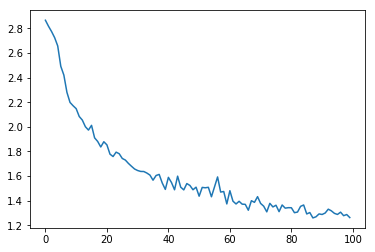

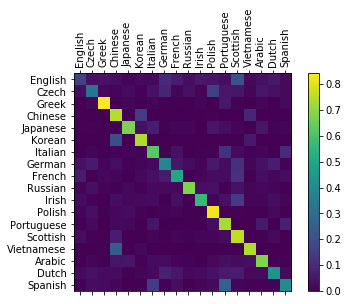

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [21]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Wang-Qiang')


> Dovesky
(-0.48) Czech
(-1.27) Russian
(-3.07) English

> Jackson
(-0.75) Scottish
(-1.63) Russian
(-1.71) English

> Satoshi
(-0.81) Italian
(-1.69) Polish
(-2.05) Japanese

> Wang-Qiang
(-0.45) Irish
(-1.66) Vietnamese
(-2.84) Portuguese
